# THE SETUP

In [1]:
# import libs
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk

In [7]:
# Variable Setup
N_training = 20   # The number of training episodes

decay_reward = 0.9  # Discount gamma for delayed reward

learning_rate_inti = 0.5   # The initial value for learning rate
epsilon_inti = 0.5         # The initial value for epsilon greedy
decay_learning_rate = 0.9  # The decay factor for learning rate
decay_epsilon = 0.9        # The decay factor for epsilon

step_list = []            # The list recording steps used in each episode
finished_episode_list = []  # record finished episode number for plot

# the environment==================
UNIT = 40   # pixels
MAZE_H = 5  # grid height number
MAZE_W = 5  # grid width number

In [3]:
# The grid class object
class Grid(tk.Tk, object):
    def __init__(self):
        super(Grid, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.title('Grid Trap')
        self.geometry('{0}x{1}'.format(MAZE_H * UNIT, MAZE_H * UNIT))
        self._build_maze()
        self.terminate_reason = ' Our agent (T＿T) fel into a black hole'

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                                height=MAZE_H * UNIT,
                                width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 3, UNIT])
        self.hell1 = self.canvas.create_oval(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        self.hell1_label = self.canvas.create_text(
            (hell1_center[0], hell1_center[1]), text="-1", fill='white', font='bold')
        # hell
        hell2_center = origin + np.array([UNIT*2, UNIT * 2])
        self.hell2 = self.canvas.create_oval(
            hell2_center[0] - 15, hell2_center[1] - 15,
            hell2_center[0] + 15, hell2_center[1] + 15,
            fill='black')
        self.hell2_label = self.canvas.create_text(
            (hell2_center[0], hell2_center[1]), text="-1", fill='white', font='bold')

        # create target
        target_center = origin + np.array([UNIT*3, UNIT * 2])
        self.oval = self.canvas.create_rectangle(
            target_center[0] - 15, target_center[1] - 15,
            target_center[0] + 15, target_center[1] + 15,
            fill='red')
        self.target_label = self.canvas.create_text(
            (target_center[0], target_center[1]), text="+1", fill='white', font='bold')
        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='yellow')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.5)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.terminate_reason = ' Our agent (T_T) fell into a black hole'
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='yellow')
        # return observation
        return self.canvas.coords(self.rect)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if np.random.uniform() < 0.9:
            # expected results if possible (not in border)
            if action == 0:   # up
                if s[1] > UNIT:
                    base_action[1] -= UNIT
            elif action == 1:   # down
                if s[1] < (MAZE_H - 1) * UNIT:
                    base_action[1] += UNIT
            elif action == 3:   # right
                if s[0] < (MAZE_W - 1) * UNIT:
                    base_action[0] += UNIT
            elif action == 2:   # left
                if s[0] > UNIT:
                    base_action[0] -= UNIT
# random results with probability 0.1
        else:
            print("Randomized action")
            rc = np.random.choice(range(3))
            if rc == 0:   # up
                if s[1] > UNIT:
                    base_action[1] -= UNIT
            elif rc == 1:   # down
                if s[1] < (MAZE_H - 1) * UNIT:
                    base_action[1] += UNIT
            elif rc == 3:   # right
                if s[0] < (MAZE_W - 1) * UNIT:
                    base_action[0] += UNIT
            elif rc == 2:   # left
                if s[0] > UNIT:
                    base_action[0] -= UNIT

        self.canvas.move(
            self.rect, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.rect)  # next state

        # reward function
        # the terminal state actually covers 3 states: the two black holes and the red target
        if s_ == self.canvas.coords(self.oval):
            reward = 1
            done = True
            self.terminate_reason = ' Our agent (>_<) won!'
            s_ = 'terminal'

        elif s_ in [self.canvas.coords(self.hell1), self.canvas.coords(self.hell2)]:
            reward = -1
            done = True
            s_ = 'terminal'

        else:
            reward = 0
            done = False

        return s_, reward, done, self.terminate_reason

    def render(self):
        time.sleep(0.1)
        self.update()


In [4]:
class QLearningTable:
    def __init__(self, actions, learning_rate, reward_decay, e_greedy):
        self.actions = actions  # actions
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.step_count = 0  # record the steps in each episode before terminate
        self.new_state_index = 1  # for print the row index

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        # print('real using epi:', self.epsilon)
        if np.random.uniform() < (1 - self.epsilon):

            # Q5.1 put your answer here; please take care about the indent
            # B
            state_action = self.q_table.loc[observation, :]
            action = np.random.choice(
                state_action[state_action == np.min(state_action)].index)
        else:
            # Q5.2 Put your answer here; please take care about the indent
            # E
            action = np.random.choice(self.actions)

        return action
# ===================================================
        """        
            # Choose your answer for Q5 from below (to complete the code).
        A):
            action = self.q_table.loc[observation, :]

        B):
            state_action = self.q_table.loc[observation, :]
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)

        C):
            state_action = self.q_table.loc[observation, :]
            action = np.random.choice(state_action[state_action == np.min(state_action)].index)

        D):
            action = self.q_table.loc[observation, 2]

        E):
            action = np.random.choice(self.actions)
            """
# ====================================================================================================

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        self.step_count += 1
        if s_ != 'terminal':
            # next state is not terminal
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update
        # print('real using lr:',self.lr)
        return self.q_table, self.step_count

    def set_lr(self, decay):
        if self.lr > 0.00001:
            self.lr = decay * self.lr
        else:
            print('Learning rate is small enough and close to 0.')
        return self.lr

    def set_epsilon(self, decay):
        if self.epsilon > 0.00001:
            self.epsilon = decay * self.epsilon
        else:
            print('epsilon is small enough and close to 0.')
        return self.epsilon

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            new_state_name = 'S' + str(self.new_state_index)
            print('Add a new state', new_state_name, ' into the Q table')
            self.new_state_index += 1
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )


In [5]:
def update():
    for episode in range(N_training):
        if episode == 0:
            print('Learning rate for episode {} is:'.format(
                episode), learning_rate_inti)
            print('Epsilon for episode {} is:'.format(episode), epsilon_inti)
        else:
            new_lr = RL.set_lr(decay_learning_rate)  # set decay learning rate
            print('Learning rate for episode {} is:'.format(episode), new_lr)
            new_epsilon = RL.set_epsilon(decay_epsilon)  # set decay epsilon
            print('Epsilon for episode {} is:'.format(episode), new_epsilon)

        # initial observation
        observation = env.reset()  # reset environment

        while True:
            # fresh env
            env.render()

            print("State before action:", decodeXY(observation))

            # RL choose action based on observation
            action = RL.choose_action(str(observation))

            print(" action chosen:", decodeAct(action))

            # RL take action and get next observation and reward
            observation_, reward, done, reason = env.step(action)

            # RL learn from this transition
            RL.learn(str(observation), action, reward, str(observation_))

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                print('Episode {} finished.{} and used {} steps'.format(
                    episode, reason, RL.step_count))
                finished_episode_list.append(episode)
                if reason == ' Our agent (>_<) won!':
                    step_list.append(RL.step_count)
                else:
                    step_list.append(None)
                RL.step_count = 0
                print('=======================================================')
                break

    # end of game
    print('Training Over')
    env.destroy()


def decodeXY(a):
    x = (a[0]-5)/40 + 1
    y = (a[1]-5)/40 + 1
    return ('row,column =' + str(int(y)) + ',' + str(int(x)))


def decodeAct(x):
    if x == 0:
        return ('u')
    elif x == 1:
        return ('d')
    elif x == 2:
        return ('l')
    elif x == 3:
        return ('r')


def indexXY(arStrng):
    temp = []
    for strng in arStrng:
        temp.append(decXY(strng))
    return (temp)


def decXY(strng):
    if strng == 'terminal':
        return strng
    else:
        comma = strng.index(',')
        a = strng[1:comma]
        if a == "5.0":
            x = 1
        elif a == "45.0":
            x = 2
        elif a == "85.0":
            x = 3
        elif a == "125.0":
            x = 4
        elif a == "165.0":
            x = 5
        if strng[comma+2:comma+5] == "5.0":
            y = 1
        elif strng[comma+2:comma+6] == "45.0":
            y = 2
        elif strng[comma+2:comma+6] == "85.0":
            y = 3
        elif strng[comma+2:comma+7] == "125.0":
            y = 4
        elif strng[comma+2:comma+7] == "165.0":
            y = 5
        return ('row,column =' + str(y) + ',' + str(x))


# The Main

Learning rate for episode 0 is: 0.5
Epsilon for episode 0 is: 0.5
State before action: row,column =1,1
Add a new state S1  into the Q table
 action chosen: u
State before action: row,column =1,1
 action chosen: l


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =1,1
 action chosen: r
Add a new state S2  into the Q table
State before action: row,column =1,2
 action chosen: r
Add a new state S3  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =1,3
 action chosen: d
Add a new state S4  into the Q table
State before action: row,column =2,3
 action chosen: r
Add a new state S5  into the Q table
Episode 0 finished. Our agent (T_T) fell into a black hole and used 6 steps
Learning rate for episode 1 is: 0.45
Epsilon for episode 1 is: 0.45


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: r
Randomized action
State before action: row,column =1,2
 action chosen: d
Add a new state S6  into the Q table
State before action: row,column =2,2
 action chosen: d
Add a new state S7  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =3,2
 action chosen: l
Add a new state S8  into the Q table
State before action: row,column =3,1
 action chosen: r
Randomized action
Add a new state S9  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =4,1
 action chosen: l
State before action: row,column =4,1
 action chosen: u
State before action: row,column =3,1
 action chosen: d
State before action: row,column =4,1
 action chosen: l
State before action: row,column =4,1
 action chosen: r
Add a new state S10  into the Q table
State before action: row,column =4,2
 action chosen: d
Add a new state S11  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =5,2
 action chosen: d
State before action: row,column =5,2
 action chosen: d
State before action: row,column =5,2
 action chosen: u
State before action: row,column =4,2
 action chosen: l
Randomized action
State before action: row,column =4,1
 action chosen: u
State before action: row,column =3,1
 action chosen: u
Add a new state S12  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =2,1
 action chosen: u
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: l
State before action: row,column =1,1
 action chosen: u
State before action: row,column =1,1
 action chosen: l
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: r
State before action: row,column =1,3
 action chosen: u
Randomized action
State before action: row,column =1,2
 action chosen: d
State before action: row,column =2,2
 action chosen: l
State before action: row,column =2,1
 action chosen: r
State before action: row,column =2,2
 action chosen: d
State before action: row,column =3,2
 action chosen: l
State before action: row,column =3,1
 action chosen: u
State before action: row,column =2,1
 action chosen: u
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: l
State before action: row,column =1,1
 action ch

/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =5,1
 action chosen: d
Randomized action
State before action: row,column =5,1
 action chosen: l
State before action: row,column =5,1
 action chosen: u
State before action: row,column =4,1
 action chosen: l
State before action: row,column =4,1
 action chosen: l
State before action: row,column =4,1
 action chosen: r
State before action: row,column =4,2
 action chosen: u
State before action: row,column =3,2
 action chosen: l
State before action: row,column =3,1
 action chosen: l
State before action: row,column =3,1
 action chosen: d
State before action: row,column =4,1
 action chosen: d
State before action: row,column =5,1
 action chosen: d
State before action: row,column =5,1
 action chosen: d
State before action: row,column =5,1
 action chosen: r
State before action: row,column =5,2
 action chosen: r
Add a new state S14  into the Q table
State before action: row,column =5,3
 action chosen: u
Add a new state S15  into the Q table


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =4,3
 action chosen: d
State before action: row,column =5,3
 action chosen: d
State before action: row,column =5,3
 action chosen: u
State before action: row,column =4,3
 action chosen: r
Randomized action
Episode 1 finished. Our agent (T_T) fell into a black hole and used 68 steps
Learning rate for episode 2 is: 0.405
Epsilon for episode 2 is: 0.405
State before action: row,column =1,1
 action chosen: d
State before action: row,column =2,1
 action chosen: u
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: r
State before action: row,column =1,3
 action chosen: l
State before action: row,column =1,2
 action chosen: l
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: u
State before action: row,column =1,2
 action chosen: r
State before action: row,column =1,3
 action chosen: u
State before action: row,column =1,3
 action chosen: l
State befo

/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(
/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =4,4
 action chosen: d
Add a new state S17  into the Q table
State before action: row,column =5,4
 action chosen: r
Add a new state S18  into the Q table
State before action: row,column =5,5
 action chosen: u
Add a new state S19  into the Q table
State before action: row,column =4,5
 action chosen: l


/var/folders/3x/7qtdp9gd4t96285blt4dfmnc0000gp/T/ipykernel_87123/1551500960.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.q_table = self.q_table.append(


State before action: row,column =4,4
 action chosen: d
State before action: row,column =5,4
 action chosen: u
State before action: row,column =4,4
 action chosen: u
Episode 2 finished. Our agent (>_<) won! and used 92 steps
Learning rate for episode 3 is: 0.36450000000000005
Epsilon for episode 3 is: 0.36450000000000005
State before action: row,column =1,1
 action chosen: l
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: r
State before action: row,column =1,3
 action chosen: d
State before action: row,column =2,3
 action chosen: r
Episode 3 finished. Our agent (T_T) fell into a black hole and used 5 steps
Learning rate for episode 4 is: 0.32805000000000006
Epsilon for episode 4 is: 0.32805000000000006
State before action: row,column =1,1
 action chosen: r
State before action: row,column =1,2
 action chosen: l
State before action: row,column =1,1
 action chosen: u
State before action: row,column =1,1
 action chosen: r
State bef

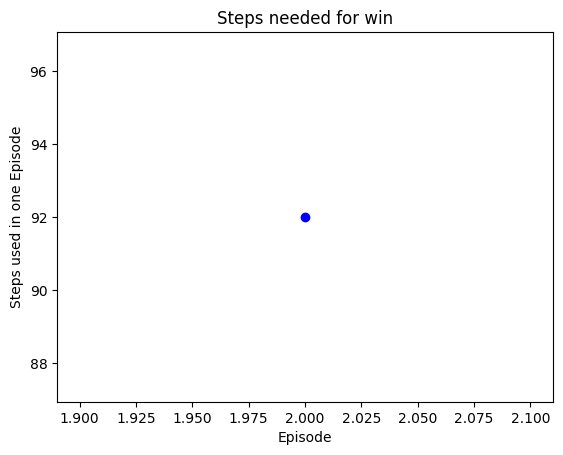

In [6]:
env = Grid()
RL = QLearningTable(actions=list(range(env.n_actions)), learning_rate=learning_rate_inti,
                    reward_decay=decay_reward, e_greedy=epsilon_inti)   # This describes the training
env.after(100, update)
env.mainloop()
# output our training result
pd.set_option('display.max_colwidth', None)
q_table = RL.q_table.rename(columns={0: 'u', 1: 'd', 2: 'l', 3: 'r'})
q_table.index = indexXY(q_table.index)
print('Q table:')
print(q_table)
plt.plot(finished_episode_list, step_list, 'bo-')
plt.title('Steps needed for win')
plt.xlabel('Episode')
plt.ylabel('Steps used in one Episode')
plt.show()